Karena data final-project terlalu sedikit untuk men-train model, saya memakai data cats vs dogs di Kaggle

* Total 25.000 train data (cats and dogs image)
* 12.500 dog, 12.500 cat

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import os

Karena memory yang terbatas, jadi saya extract image menjadi:

* Shape: height 128 x width 128
* Channel: grayscale

Lalu normalize agar menjadi 0 - 1 supaya lebih cepat CONVERGE

In [4]:
IMGSIZE= 128

def create_train_data(path):
    X = []
    y = []
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) # IMREAD_COLOR
        img_arr = cv2.resize(img_arr, (IMGSIZE, IMGSIZE))
        img_arr = img_arr / 255.0  # normalize
        cat = np.where(img.split('.')[0] == 'dog', 1, 0)
        
        X.append(img_arr)
        y.append(cat)
    
    X = np.array(X).reshape(-1, IMGSIZE, IMGSIZE, 1)
    y = np.array(y)
    
    return X, y        

In [5]:
# Create Train Data

train_data, label_data = create_train_data('../working/train/train')

100%|██████████| 25000/25000 [00:31<00:00, 786.98it/s]


In [6]:
train_data.shape, label_data.shape, train_data.dtype

((25000, 128, 128, 1), (25000,), dtype('float32'))

Supaya tidak over-memory (crash), saya menghapus file di output kernel

Kode untuk review image

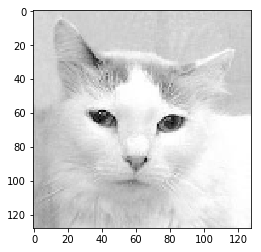

In [8]:
check_image = train_data[12000].reshape(128, 128)

plt.imshow(check_image, cmap=plt.cm.gray)
plt.show()

Create a model

In [9]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical # one-hot encoding

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

tf.__version__

Using TensorFlow backend.


'2.1.0'

In [10]:
label_data = to_categorical(label_data, num_classes=2)

Saya pakai 10% validation data utk evaluasi model accuracy

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data, label_data, test_size=0.1, random_state=11)

In [12]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((22500, 128, 128, 1), (2500, 128, 128, 1), (22500, 2), (2500, 2))

In [27]:
model = Sequential()

# first layer

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# second layer

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))

model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

# third layer

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

In [28]:
# compile model

model.compile(optimizer=RMSprop(lr=0.001),
              loss='categorical_crossentropy', metrics=['accuracy'])

Saya gunakan ReduceLROnPlateau untuk mengurangi learning rate, jika model stop improving ketika training

Goal-nya adalah untuk mendapatkan akurasi yang lebih baik

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

Gunakan ModelCheckpoint untuk save & menggunakan validation accuracy tertinggi yang didapatkan dalam epochs

In [30]:
model_save = ModelCheckpoint('best_model.hdf5', save_best_only=True)

Data Augmentation

* Training data cuma ada 25.000, sedangkan Deep Learning butuh HUGE TRAINING DATA utk mencapai akurasi tinggi
* Jadi saya gunakan ImageDataGenerator untuk transform train data menjadi lebih banyak & bervariasi

In [31]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


datagen.fit(X_train)

Saya gunakan:
* Data Augmentation
* 40 epochs
* ReduceLROnPlateau
* ModelCheckpoint

In [32]:
# fitting model

batch_size = 32

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs=40, validation_data=(X_val, y_val),
                              verbose=1,
                              callbacks=[learning_rate_reduction, model_save]) 

Train for 704 steps, validate on 2500 samples
Epoch 1/40
704/704 [==============================] - 51s 73ms/step - loss: 0.6894 - accuracy: 0.5701 - val_loss: 0.6361 - val_accuracy: 0.6388
Epoch 2/40
704/704 [==============================] - 51s 72ms/step - loss: 0.6419 - accuracy: 0.6384 - val_loss: 0.6101 - val_accuracy: 0.6708
Epoch 3/40
704/704 [==============================] - 50s 71ms/step - loss: 0.6053 - accuracy: 0.6775 - val_loss: 0.5732 - val_accuracy: 0.7048
Epoch 4/40
704/704 [==============================] - 50s 71ms/step - loss: 0.5853 - accuracy: 0.6928 - val_loss: 0.5749 - val_accuracy: 0.7116
Epoch 5/40
704/704 [==============================] - 50s 71ms/step - loss: 0.5734 - accuracy: 0.7032 - val_loss: 0.5475 - val_accuracy: 0.7212
Epoch 6/40
704/704 [==============================] - 50s 72ms/step - loss: 0.5609 - accuracy: 0.7178 - val_loss: 0.5115 - val_accuracy: 0.7444
Epoch 7/40
704/704 [==============================] - 50s 71ms/step - loss: 0.5490 - accur

* Validation loss lebih rendah daripada train loss
* Validation accuracy juga lebih tinggi daripada train accuracy

Ada beberapa kemungkinan:

* Saya gunakan ImageDataGenerator hanya pada train data, tetapi tidak pada validation data (terlalu simple jadinya dibandingkan train data yg di-transform)
* Model terlalu kompleks / regularization yang terlalu banyak (over-regularization)

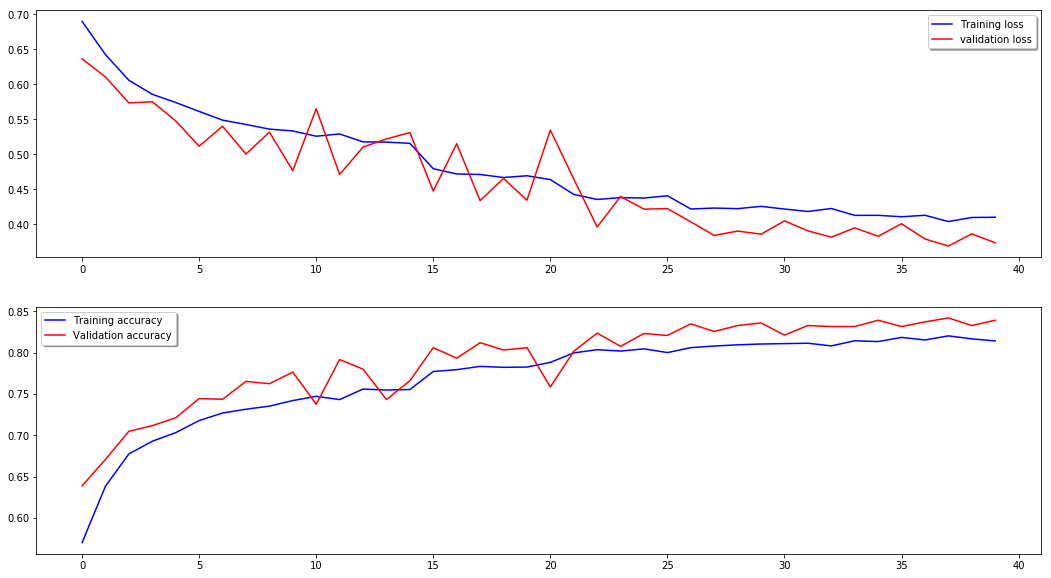

In [33]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

Lalu saya upload final-project validation dataset (saya upload dahulu ke Kaggle Dataset) untuk testing model accuracy

In [35]:
IMGSIZE= 128

def create_test_data(path):
    X = []
    y = []
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) # IMREAD_COLOR
        img_arr = cv2.resize(img_arr, (IMGSIZE, IMGSIZE))
        img_arr = img_arr / 255.0
        cat = np.where(img.split('.')[0] == 'dog', 1, 0)
        
        X.append(img_arr)
        y.append(cat)
    
    X = np.array(X).reshape(-1, IMGSIZE, IMGSIZE, 1)
    y = np.array(y)
    
    return X, y        

In [45]:
# Create Train Data

X_test, y_test = create_test_data('../input/cat-vs-dogs-validation-indo/validation/cats dogs')

100%|██████████| 1000/1000 [00:02<00:00, 443.27it/s]


In [46]:
X_test.shape, y_test.shape

((1000, 128, 128, 1), (1000,))

Making prediction menggunakan weights yang memiliki accuracy terbaik di validation accuracy

In [47]:
model.load_weights('best_model.hdf5')

predict = model.predict_classes(X_test)

In [48]:
final_result = pd.DataFrame({'actual label': y_test, 'prediction': predict})

In [57]:
len(final_result[final_result['actual label'] == final_result['prediction']]) / y_test.shape[0] * 100

85.3

Model ini mencapai 85.3% accuracy

Saya rasa ini not-bad untuk project pertama saya di CNN, tetapi pasti akan saya tingkatkan lagi kedepannya